In [1]:
import sys
sys.path.append('../src')

import torch
import numpy as np
from torchvision import transforms

from data.wiki_dataset import WikiDataset
from model.rnn import RNN
from model.l_mixed import LMixed
from utils.utils import train_model, read_word2vec_file
from utils.visualize import visualize_result

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = '../data/labelled_data.csv'
EMBEDDING_DIM = 100
TX = 30
UNKNOWN_VEC = [0] * EMBEDDING_DIM # '<UNK>'
PADDING_VEC = [0] * EMBEDDING_DIM # '<PAD>'


np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Read word2vec file to a dictionary
word2vec_dict = read_word2vec_file('../data/word2vec_vi_syllables_100dims.txt')
word2vec_dict['<UNK>'] = UNKNOWN_VEC
word2vec_dict['<PAD>'] = PADDING_VEC

In [4]:
def custom_transform(x):
    x = x.lower()
    x = x.split()
    if len(x) < 30:
        x = x + ['<PAD>'] * (TX - len(x))
    elif len(x) > 30:
        x = x[:30]
    x = [word2vec_dict.get(word, UNKNOWN_VEC) for word in x]
    x = torch.tensor(x)
    return x

transform = transforms.Compose([
    custom_transform,
])


train_dataset = WikiDataset(data_path=DATA_PATH, train=True, transform=transform)
train_loader = train_dataset.get_data_loader()

val_dataset = WikiDataset(data_path=DATA_PATH, train=False, transform=transform)
val_loader = val_dataset.get_data_loader()

# Experiments

## RNN

Epoch 1/100, Train Loss: 1.4852, Train Acc: 0.5310, Val Loss: 1.3346, Val Acc: 0.6400
Epoch 2/100, Train Loss: 1.1993, Train Acc: 0.6311, Val Loss: 1.0960, Val Acc: 0.6400
Epoch 3/100, Train Loss: 1.0956, Train Acc: 0.6311, Val Loss: 1.0521, Val Acc: 0.6400
Epoch 4/100, Train Loss: 1.0540, Train Acc: 0.6311, Val Loss: 1.0211, Val Acc: 0.6400
Epoch 5/100, Train Loss: 0.9923, Train Acc: 0.6357, Val Loss: 1.0058, Val Acc: 0.6618
Epoch 6/100, Train Loss: 0.9456, Train Acc: 0.6621, Val Loss: 0.9721, Val Acc: 0.6618
Epoch 7/100, Train Loss: 0.9123, Train Acc: 0.6794, Val Loss: 0.9471, Val Acc: 0.6582
Epoch 8/100, Train Loss: 0.8777, Train Acc: 0.6922, Val Loss: 0.8947, Val Acc: 0.6764
Epoch 9/100, Train Loss: 0.8121, Train Acc: 0.7040, Val Loss: 0.7890, Val Acc: 0.6909
Epoch 10/100, Train Loss: 0.6979, Train Acc: 0.7295, Val Loss: 0.6425, Val Acc: 0.7818
Epoch 11/100, Train Loss: 0.6286, Train Acc: 0.7732, Val Loss: 0.6070, Val Acc: 0.7782
Epoch 12/100, Train Loss: 0.6096, Train Acc: 0.7741,

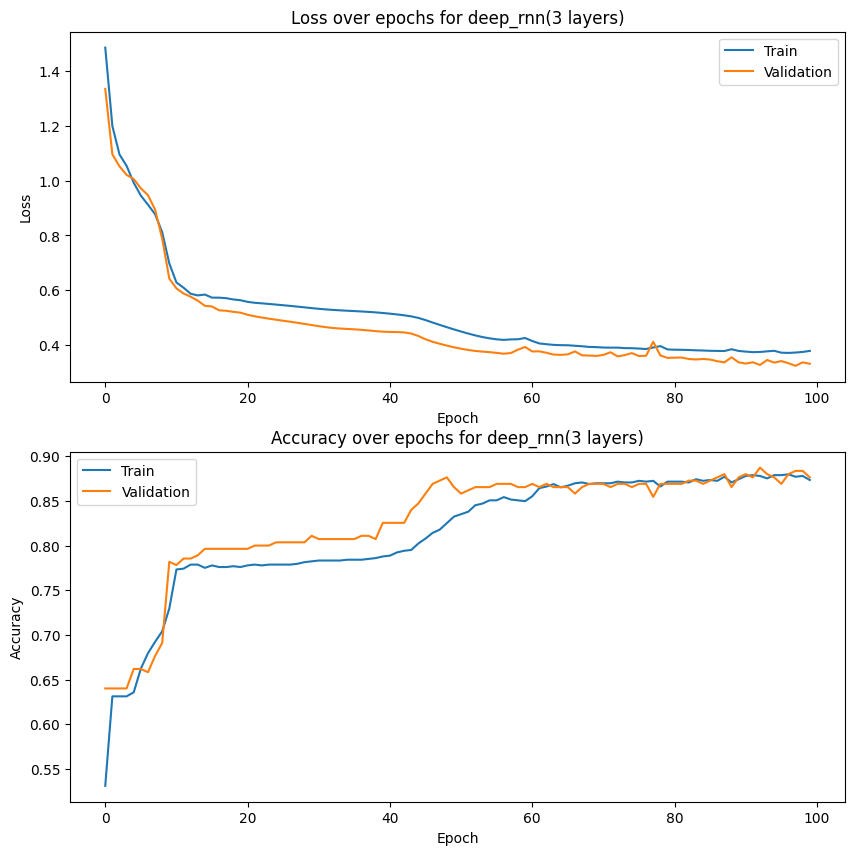

In [5]:
my_rnn = RNN(input_size=EMBEDDING_DIM, hidden_size=64, num_classes=5, num_layers=3)

# Hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_rnn.parameters(), lr=0.0001)
epochs = 100

rnn_result = train_model(model=my_rnn,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    num_epochs=epochs,
                    return_results=True,
                    device=device)

visualize_result(rnn_result, 'deep_rnn(3 layers)')

## LMixed

In [10]:
my_lmixed = LMixed(input_size=EMBEDDING_DIM, hidden_size=64, num_classes=5)

# Hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_lmixed.parameters(), lr=0.00005)
epochs = 100

lmixed_result = train_model(model=my_lmixed,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    num_epochs=epochs,
                    return_results=True,
                    device=device)

visualize_result(lmixed_result, 'L mixed (supervised only)')

Epoch 1/100, Train Loss: 1.6015, Train Acc: 0.6129, Val Loss: 1.5981, Val Acc: 0.6400
Epoch 2/100, Train Loss: 1.5947, Train Acc: 0.6311, Val Loss: 1.5908, Val Acc: 0.6400
Epoch 3/100, Train Loss: 1.5869, Train Acc: 0.6311, Val Loss: 1.5819, Val Acc: 0.6400
Epoch 4/100, Train Loss: 1.5770, Train Acc: 0.6311, Val Loss: 1.5702, Val Acc: 0.6400
Epoch 5/100, Train Loss: 1.5631, Train Acc: 0.6311, Val Loss: 1.5524, Val Acc: 0.6400
Epoch 6/100, Train Loss: 1.5390, Train Acc: 0.6311, Val Loss: 1.5163, Val Acc: 0.6400
Epoch 7/100, Train Loss: 1.4777, Train Acc: 0.6311, Val Loss: 1.4145, Val Acc: 0.6400
Epoch 8/100, Train Loss: 1.3598, Train Acc: 0.6311, Val Loss: 1.3118, Val Acc: 0.6400
Epoch 9/100, Train Loss: 1.3062, Train Acc: 0.6311, Val Loss: 1.2896, Val Acc: 0.6400
Epoch 10/100, Train Loss: 1.2940, Train Acc: 0.6311, Val Loss: 1.2819, Val Acc: 0.6400
Epoch 11/100, Train Loss: 1.2885, Train Acc: 0.6311, Val Loss: 1.2777, Val Acc: 0.6400
Epoch 12/100, Train Loss: 1.2852, Train Acc: 0.6311,

KeyboardInterrupt: 